In [52]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'

from definitions import ROOT_DIR
from unc.utils import load_info

In [30]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"


In [31]:
level = 8
all_paths = {
#     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
    f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn'),
    f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn_lstm'),

}

plot_info = {
    f'uf{level}a_cnn': {'color': emerald, 'label': 'Ground-truth map'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0': {'color': peter_river, 'label': 'LSTM + normal mapping'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95': {'color': wisteria, 'label': 'LSTM + uncertainty'},
    f'uf{level}m_cnn_uncertainty_decay_1.0': {'color': green_sea, 'label': 'Normal mapping'},
    f'uf{level}m_cnn_uncertainty_decay_0.85': {'color': pumpkin, 'label': 'Normal mapping + uncertainty'}
}

plot_order = [
#     f'uf{level}a_cnn',
    f'uf{level}m_cnn_uncertainty_decay_1.0',
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0',
    f'uf{level}m_cnn_uncertainty_decay_0.85',
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [7]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
        if args["total_steps"] < 2e6:
            continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [8]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [9]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

In [10]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [11]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [12]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [13]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [27]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf8m_cnn_uncertainty_decay_0.65': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=0.65, slip_prob=0.1, trunc=10),
  21.907600000000002,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/493405854da683ce6f8f7945664c9b9c_Fri May 13 22:23:04 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/e3d624513b9899175f3e4f46ae9c9a29_Fri May 13 22:23:04 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/57c0ce99c79d07e2a42e24812d8bcfc1_Fri May 13 22:23:04 2022.npy')]),
 'uf8m_cnn_uncertainty_decay_1.0': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=1.0, slip_prob=0.1, trunc=10),
  18.512466666666665,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/3494ddf68510bdbdd704ac108f6abbb6_Fri May 13 21:46:24 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/22b10f7c45735e485973e568049c9000_Fri May 13 21:46:24 2022.npy'),
   P

In [17]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [18]:
all_mapped_data_slip

{'uf8m_cnn_uncertainty_decay_0.65': array([[ 0.84,  4.34,  3.54, ..., 26.68, 28.34, 27.26],
        [13.4 , 12.46, 11.64, ..., 18.76, 23.34, 20.72],
        [14.24, 10.8 , 18.9 , ..., 18.74, 20.36, 22.2 ]]),
 'uf8m_cnn_uncertainty_decay_1.0': array([[ 7.58,  4.58,  4.42, ..., 18.74, 19.4 , 20.6 ],
        [ 3.72, 14.8 , 10.54, ..., 19.32, 16.12, 16.58],
        [ 4.98,  3.96,  3.38, ..., 19.9 , 20.46, 20.7 ]]),
 'uf8m_cnn_uncertainty_decay_0.85': array([[ 2.16,  1.98, 12.14, ..., 26.7 , 28.68, 28.  ],
        [14.98, 15.76, 13.28, ..., 27.2 , 30.14, 27.6 ],
        [ 7.44, 10.76, 16.98, ..., 29.18, 27.06, 27.62]]),
 'uf8m_cnn_uncertainty_decay_0.95': array([[ 4.28, 13.42, 16.96, ..., 19.4 , 18.76, 17.14],
        [ 5.26, 10.02,  5.88, ..., 27.3 , 28.48, 27.64],
        [ 8.08,  9.82, 13.98, ..., 26.3 , 27.86, 24.34]]),
 'uf8m_cnn_lstm_uncertainty_decay_0.85': array([[12.12, 15.22, 20.32, ..., 25.02, 26.82, 25.1 ],
        [ 2.72, -2.36, 17.76, ..., 26.36, 23.  , 25.38],
        [15.36,

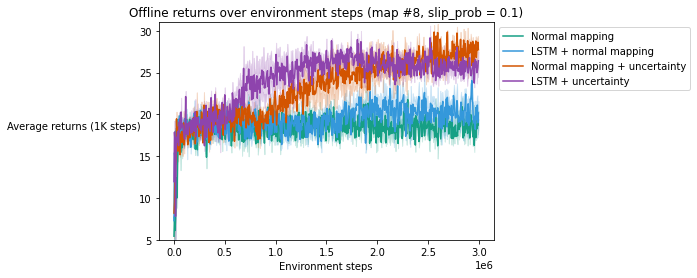

In [49]:
# with slip
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 5000


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(5, 31)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

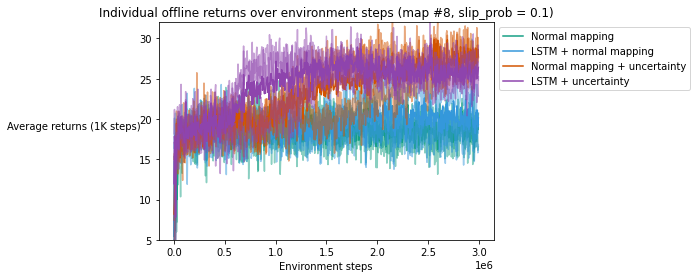

In [50]:
# with slip
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 5000


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    ax.plot(x, means, label=key, color=color)

    for d in data:
        ax.plot(x, d, color=color, alpha=0.5)
#     plt.fill_between(x, means - std_err, means + std_err,
#                          color=color, alpha=0.2)

ax.set_ylim(5, 32)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Individual offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [37]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [38]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=100)


In [39]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf8m_cnn_lstm_trunc_10': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=10),
  19.060533333333336,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/db06402bf7ae256f14c824c8f3299480_Fri May 13 17:11:04 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/94a32a1e0a0b5b51c387b9ec13f6d619_Fri May 13 17:11:04 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/7a2e0482ec108b5af6b48c4c771ec318_Fri May 13 17:11:04 2022.npy')]),
 'uf8m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=1),
  20.16726666666667,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/6165eb99297b5514ff374d4ebb07814f_Fri May 13 17:38:15 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/3bb5b164a6f41f44c253959d728f2d71_Fri May 13 17:29:06 20

In [40]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


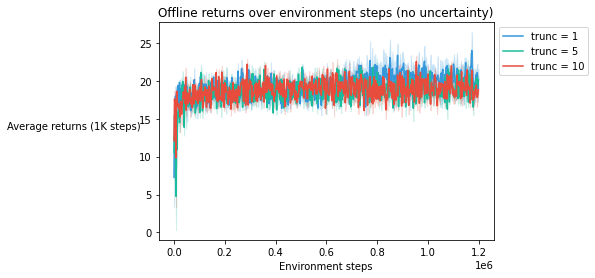

In [41]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


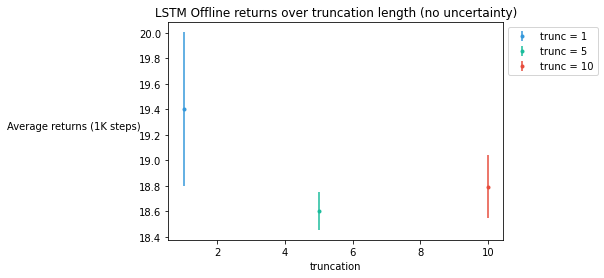

In [44]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [46]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf8m_cnn_lstm_trunc_10': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1, trunc=10),
  24.631066666666666,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/d9fd56d5d1b5aa709410bb1d9dc177a4_Fri May 13 17:20:36 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/4edb8a84e752716b8e984e05ed3a68f6_Fri May 13 17:24:42 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/7608d5f3d7af87bd4b93195add40005c_Fri May 13 17:24:42 2022.npy')]),
 'uf8m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1, trunc=1),
  25.7264,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/34dbfe58aed5f6af7fb009b5dc3bd07c_Fri May 13 17:38:02 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn_lstm/8fa06940db2013494996290e891e8acc_Fri May 13 17:38:15 2022.npy')

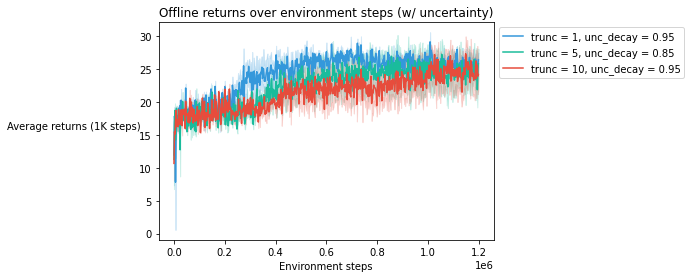

In [53]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'}
}


fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [24.5716     25.1923     22.85496667]
k: 5, step_means: [24.10026667 18.5381     24.1317    ]
k: 10, step_means: [21.5127 18.3967 24.2826]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


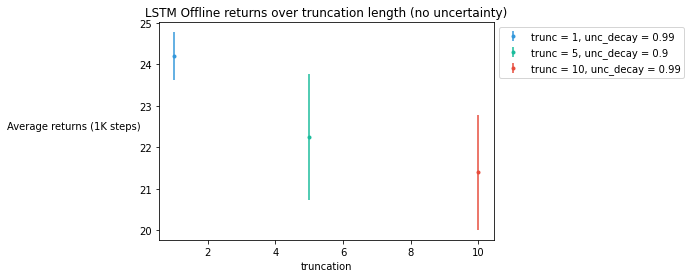

In [51]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')